# Color GAN
An implementation of `Unsupervised Diverse Colorization via Generative Adversarial Networks`

Paper: https://arxiv.org/pdf/1702.06674.pdf

Code: https://github.com/ccyyatnet/COLORGAN

Data: https://github.com/fyu/lsun

In [2]:
import lmdb
import io
import os
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, Dense, BatchNormalization, ReLU, LeakyReLU, Flatten

## Data
The dataset is a subset the `scenes` color images from `LSUN`. We will be using the validation bedroom dataset instead of the training set because the training set is very large.

The images in the dataset are of various sizes; here we define a function to trim them to $64 \times 64$ pixels.

In [3]:
def trim_image(image, height, width):
    image_height = image.shape[0]
    image_width = image.shape[1]
    
    out = image.copy()
    if image_height > height:
        top = (image_height-height)//2
        bottom = image_height-height-top
        out = out[top:-bottom, :, :]
    if image_width > width:
        left = (image_width-width)//2
        right = image_width-width-left
        out = out[:, left:-right, :]
    return out

We load and preprocess the images from a mdb file stored as bytes. We convert them to numpy float array in `YUV` colorspace for training later on.

In [4]:
def get_image_data(db_path):
    env = lmdb.open(db_path, map_size=1099511627776,
                    max_readers=100, readonly=True)
    images = []
    with env.begin(write=False) as txn:
        cursor = txn.cursor()
        for key, val in cursor:
            # Get image data in bytes
            img = io.BytesIO(val)
            # Convert to numpy array in RGB space
            img = np.array(Image.open(io.BytesIO(val)).convert('RGB'))
            # Trim to 64*64 pixels from the center
            img = trim_image(img, 64, 64)
            # Convert to YUV color space
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            # Scale value to be in [-1, 1]
            img = img/127.5 - 1
            images.append(img)
    return np.array(images)

In [5]:
images = get_image_data('bedroom_val_lmdb')
images.shape

(300, 64, 64, 3)

We have 300 images in the dataset.

# Model
The GAN model consists of a generator and a discriminator.

In [29]:
# Define model Global variables
z_dim = 100
img_height = 64
img_width = 64
batch_size = 64
epochs = 100
g_learning_rate = 1e-4
d_learning_rate = 2e-4
adam_beta1 = 0.5

In [30]:
# Define generator and discriminator
def make_generator_model():
    L = Input((img_height,img_width,1), name='L')
    z = Input((z_dim), name='z')

    h0 = Dense(img_height*img_width)(z)
    h0 = tf.reshape(h0, [-1, img_height, img_width, 1])
    h0 = BatchNormalization()(h0)
    h0 = ReLU()(h0)

    h1 = Concatenate(axis=3)([L, h0])
    h1 = Conv2D(128, (7,7), padding='same')(h1)
    h1 = BatchNormalization()(h1)
    h1 = ReLU()(h1)

    h2 = Concatenate(axis=3)([L, h1])
    h2 = Conv2D(64, (5,5), padding='same')(h2)
    h2 = BatchNormalization()(h2)
    h2 = ReLU()(h2)

    h3 = Concatenate(axis=3)([L, h2])
    h3 = Conv2D(64, (5,5), padding='same')(h3)
    h3 = BatchNormalization()(h3)
    h3 = ReLU()(h3)

    h4 = Concatenate(axis=3)([L, h3])
    h4 = Conv2D(64, (5,5), padding='same')(h4)
    h4 = BatchNormalization()(h4)
    h4 = ReLU()(h4)

    h5 = Concatenate(axis=3)([L, h4])
    h5 = Conv2D(32, (5,5), padding='same')(h5)
    h5 = BatchNormalization()(h5)
    h5 = ReLU()(h5)

    h6 = Concatenate(axis=3)([L, h5])
    h6 = Conv2D(2, (5,5), padding='same', activation='tanh')(h6)

    return tf.keras.Model(inputs=[L, z], outputs=h6)

def make_discriminator_model():
    image = Input((img_height,img_width,2), name='image')
    h0 = Conv2D(64, (5,5), padding='same')(image)
    h0 = LeakyReLU(0.2)(h0)

    h1 = Conv2D(128, (5,5), padding='same')(h0)
    h1 = BatchNormalization()(h1)
    h1 = LeakyReLU(0.2)(h1)

    h2 = Conv2D(256, (5,5), padding='same')(h1)
    h2 = BatchNormalization()(h2)
    h2 = LeakyReLU(0.2)(h2)

    h3 = Conv2D(512, (5,5), padding='same')(h2)
    h3 = BatchNormalization()(h3)
    h3 = LeakyReLU(0.2)(h3)

    h4 = Flatten()(h3)
    h4 = Dense(64)(h4)

    h5 = Dense(1)(h4)
    return tf.keras.Model(inputs=image, outputs=h5)

In [31]:
# Loss functions
def generator_loss(logits_fake):
    return -tf.reduce_mean(logits_fake)

def discriminator_loss(logits_real, logits_fake):
    return -tf.reduce_mean(logits_real - logits_fake)

In [32]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [33]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=g_learning_rate, beta_1=adam_beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=d_learning_rate)

In [34]:
@tf.function
def train_step(train_data, z):
    L = train_data[:,:,:,:1]
    y = train_data[:,:,:,1:]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([L, z], training=True)

        logits_real = discriminator(y, training=True)
        logits_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(logits_fake)
        disc_loss = discriminator_loss(logits_real, logits_fake)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [35]:
def train(train_images):
    for epoch in range(epochs):
        indices = np.arange(0,256,batch_size)
        for idx in indices:
            end = np.minimum(256, idx+batch_size)
            train_data = train_images[idx:end]
            z = tf.random.uniform((train_data.shape[0], z_dim),-1,1)
            train_step(train_data, z)

        if (epoch + 1) % 10 == 0:
            L = train_images[-10:,:,:,:1]
            y = train_images[-10:,:,:,1:]
            z = tf.random.uniform((10, z_dim),-1,1)
            generated_images = generator([L, z], training=False)

            logits_real = discriminator(y, training=False)
            logits_fake = discriminator(generated_images, training=False)

            gen_loss = generator_loss(logits_fake)
            disc_loss = discriminator_loss(logits_real, logits_fake)          
            print('Epcoh: %d, generator loss: %.2f, discriminator loss: %.2f'%(epoch+1, gen_loss, disc_loss))

In [36]:
# Train/Test split
train_images = images[:256]
test_images = images[256:]

In [39]:
train(train_images)

Epcoh: 10, generator loss: 910.64, discriminator loss: -1297.19
Epcoh: 20, generator loss: 6662.25, discriminator loss: 15749.31
Epcoh: 30, generator loss: 66047.02, discriminator loss: -12573.32
Epcoh: 40, generator loss: 31443.88, discriminator loss: 426.37
Epcoh: 50, generator loss: 26860.63, discriminator loss: 31670.52
Epcoh: 60, generator loss: 59077.86, discriminator loss: -1731.75
Epcoh: 70, generator loss: 18348.89, discriminator loss: 22746.99
Epcoh: 80, generator loss: -5317.13, discriminator loss: 16089.72
Epcoh: 90, generator loss: 106740.91, discriminator loss: -65253.17
Epcoh: 100, generator loss: -2937.54, discriminator loss: -5066.16


# Sample Output
Let's check some the colorization on test set.

### Real Images

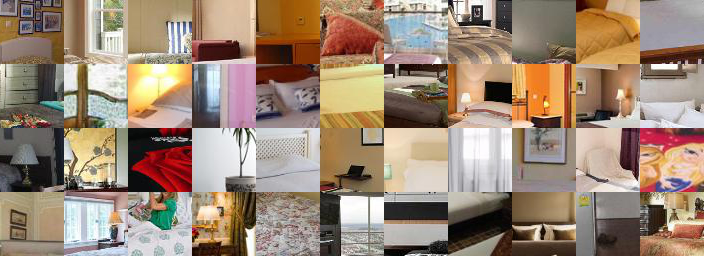

In [67]:
# There are 44 images in the test set, we will reshape the array to make one large collage.
img = test_images
img = (img+1)*127.5
collage = np.zeros((4*64, 11*64, 3))
counter = 0
for i in range(4):
    for j in  range(11):
      collage[i*64:(i+1)*64, j*64:(j+1)*64] = img[counter]
      counter += 1
collage = cv2.cvtColor((collage).astype('uint8'), cv2.COLOR_YUV2RGB)
display(Image.fromarray(collage))

### Generated Images

In [71]:
L = test_images[:,:,:,:1]
z = tf.random.uniform((L.shape[0], z_dim),-1,1)
generated_images = generator([L, z], training=False)

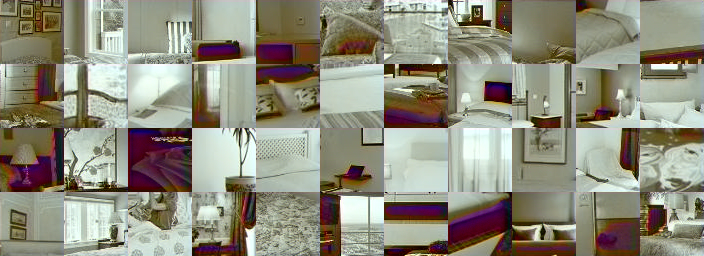

In [72]:
img = np.concatenate((L, generated_images), axis=3)
img = (img+1)*127.5
collage = np.zeros((4*64, 11*64, 3))
counter = 0
for i in range(4):
    for j in  range(11):
      collage[i*64:(i+1)*64, j*64:(j+1)*64] = img[counter]
      counter += 1
collage = cv2.cvtColor((collage).astype('uint8'), cv2.COLOR_YUV2RGB)
display(Image.fromarray(collage))

The colorizations here is not great. However, the model was trained on a much smaller subset of the original dataset and the results could be improved with more epochs as well. We can also see the model trying to color the correct area (as opposed to white space) in the images as well, albeit not quite the right colors.